In [1]:
 %matplotlib inline

import numpy as np 
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#import sklearn.ensemble.RandomForestClassifier as RandomForestClassifier
import pandas as pd

In [2]:
data_directory = '50States10K'

train_dataset = datasets.ImageFolder(data_directory, transforms.Compose([transforms.ToTensor()]))
validation_dataset = []

batch_size = 4

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
validation_loader = []




Sample Set of Images:


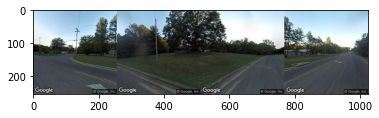

In [3]:
example_batch = next(iter(data_loader))[0]
stacked = example_batch[0]
for i in range(1, 4):
    stacked = torch.cat((stacked,example_batch[i]), 2)
print("Sample Set of Images:")
plt.imshow(stacked.permute(1, 2, 0))

In [16]:
dataframe = pd.DataFrame()

ctr = 0

# for data, label in data_loader:
#     num = data.numpy()
#     dataframe.append(num)
#     ctr += 1
#     if (ctr > 1000):
#         break
    #dataframe.insert()


[[[[0.77254903 0.77254903 0.77254903 ... 0.68235296 0.6862745
    0.6862745 ]
   [0.77254903 0.77254903 0.77254903 ... 0.68235296 0.6862745
    0.6862745 ]
   [0.77254903 0.77254903 0.77254903 ... 0.68235296 0.68235296
    0.68235296]
   ...
   [0.25882354 0.25490198 0.25490198 ... 0.03529412 0.11764706
    0.05882353]
   [0.25490198 0.25882354 0.25882354 ... 0.07058824 0.01960784
    0.13333334]
   [0.2509804  0.25490198 0.2627451  ... 0.05098039 0.11372549
    0.04313726]]

  [[0.88235295 0.88235295 0.88235295 ... 0.8352941  0.8392157
    0.8392157 ]
   [0.88235295 0.88235295 0.88235295 ... 0.8352941  0.8392157
    0.8392157 ]
   [0.88235295 0.88235295 0.88235295 ... 0.84313726 0.84313726
    0.84313726]
   ...
   [0.29411766 0.2901961  0.2901961  ... 0.05098039 0.13333334
    0.07450981]
   [0.2901961  0.29411766 0.29411766 ... 0.08627451 0.03529412
    0.14901961]
   [0.28627452 0.2901961  0.29803923 ... 0.06666667 0.12941177
    0.05882353]]

  [[0.9764706  0.9764706  0.9764706  .

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid